***
*Workshop:* [TTSM (Technology & Thought in Sonic Media) summer school 2023](https://ttsm.link/) - Symbolic Music Data Processing and Generation

*Instructor:* Jingwei Liu (Music department, UC San Diego)
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Implementation</span> 


# Generate Music by Trained RNN

As somehow unexpected, my main audience in this workshop are musicians and creative artists. This lighthearted file is designed for people without strong elementary programming skills but still interested in applying the results to some of their projects or just experimenting with new ideas. However, it's worth pointing out that the final generation stage is not the focus of this series. The goal of this workshop is to deliver some fundamental knowledge in MIDI and algorithmic music generation, as well as basic structures of such systems. The generating result is a side product of this endeavor, and since it's a fundamental teaching series, the generated results are not well tuned by advanced neural networks or large-scale dataset. We are using a toy model to perform some elementary exercises for teaching purposes. This immature system is uncomparable to the industrial machine learning platforms in the market.

Derived from our workshop, this file is runnable under minimum conditions. There is no need for GPU, no training, no burdensome data files and no programming requirements. All you need is the pretrained parameter file *'parameters_trained.pt'* I uploaded along with this notebook, and the few packages in the next block. To generate solo cello pieces with this model, there are two modifiable parameters: freely choosing a start note in step 2 and set the number of notes you want to generate in step 4. 

Hope this file can alleviate your frustration with the tutorials in some way and give you some inspirations for your project! That being said, don't give up on the hard part and do the homework, you'll get more when you solve those problems!!

In [3]:
import numpy as np
import pandas as pd
from music21 import *
import py_midicsv as pm
import torch

### Step 1. Load Trained Parameters

In [66]:
W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn = torch.load('parameters_trained.pt')
print(f'W_ax = {W_ax},  W_aa = { W_aa}, b_a = {b_a}, W_yd = {W_yd}, W_yn = {W_yn}, b_yn = {b_yn}')

W_ax = tensor([[ 3.5678e-01,  5.0505e-02,  2.1184e-01, -3.3517e-01,  7.1000e-01,
         -4.0412e-01, -2.6170e-01, -5.2598e-03, -3.9417e-01,  5.2516e-03,
          5.2722e-01, -4.8117e-01, -3.9672e-01, -4.6308e-01,  5.0476e-01,
          9.3346e-01, -9.4205e-01, -7.7360e-01, -2.8602e-01, -1.0569e+00,
          1.2684e-01,  1.1928e+00, -8.0480e-02, -9.4864e-01, -3.4318e-02,
         -3.1011e-01, -3.6058e-01, -1.2642e-01,  4.3303e-01, -1.3959e-01,
          5.6106e-01,  2.4229e-02, -3.7595e-01,  2.6638e-01,  5.4115e-01,
         -9.3791e-01, -6.3579e-01, -1.5799e-01,  3.1595e-01, -1.6265e-01,
          1.0586e-01,  5.0465e-01,  1.5162e-01,  1.4986e-01, -8.4545e-02,
         -2.5349e-01,  8.8314e-02],
        [ 2.3242e-01,  4.3650e-01,  3.3407e-01,  5.2776e-01,  3.3427e-01,
          7.0821e-01,  7.5073e-01,  1.2574e+00,  1.3114e+00,  1.1309e+00,
          1.3293e+00,  6.7179e-01, -2.2973e-01, -8.7973e-02, -2.5977e-01,
         -6.9562e-01, -1.3301e+00, -1.1681e+00, -3.9543e-01, -9.3591e

Operate on CPU and numpy:

In [67]:
W_ax = W_ax.detach().to("cpu").numpy()
W_aa = W_aa.detach().to("cpu").numpy()
b_a = b_a.detach().to("cpu").numpy()
W_yd = W_yd.detach().to("cpu").numpy()
b_yd = b_yd.detach().to("cpu").numpy()
W_yn = W_yn.detach().to("cpu").numpy()
b_yn = b_yn.detach().to("cpu").numpy()

### Step 2. Choose a note to start

There are 3 parameters for the initial note:

- note value: MIDI number for the note, an integer $\in [36,67]$, *e.g. C4 = 60*
- duration: the duration of the note in 32nd note length, an interger from the set {1, 2, 4, 5, 6, 8 ,10, 12, 14, 20}, *e.g. 8th note length = 4*
- onset: the start position of the piece relative to the first bar, an interger $\in [0,32)$ in unit of 32nd note. The music is default in 4/4, so there are 32 32nd notes per measure, *e.g. starting from the 4th beat = 24; starting from the top of the bar = 0*

**Please modify the 3 parameters below:**

In [38]:
note_value = 43
duration = 2     # 32nd note
onset = 28  # 32nd note

### Step 3. Define Functions

In [39]:
dur_list = np.array([ 1,  2,  4,  5,  6,  8, 10, 12, 14, 20])
dur_list

array([ 1,  2,  4,  5,  6,  8, 10, 12, 14, 20])

In [40]:
def str_level(onset, measure_quarterLength, beat_quarterLength):
    onset = onset/8  # quarter length
    
    if onset%measure_quarterLength == 0:
        level = 0
    elif onset%beat_quarterLength == 0:
        level = 1
    else:
        le = beat_quarterLength
        for j in range(2,5):
            le = le/2
            if onset%le == 0:
                level = j
                break
    return level

In [41]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

In [52]:
def forward_step_duration(x_n, x_d, x_l, a_prev, W_ax, W_aa, b_a, W_yd, b_yd, dur_list):
    """
    One step prediction in Figure 1
    
    Arguments:
    x_n -- note input one-hot numpy array of shape (32,1)
    x_d -- duration input one-hot numpy array of shape (10,1)
    x_l -- structure level input one-hot numpy array of shape (5,1)
    a_prev -- previous memory a, numpy array of shape (20,1)
    Parameters -- W_ax: Size([20, 47])
                W_aa: Size([20, 20])
                b_a: Size([20, 1])
                W_yd: Size([10, 20])
                b_yd: Size([10, 1])
    dur_list -- list of duarations, numpy array of shape (10,)
                
    
    Returns:
    a_next -- next memory a, numpy array of shape (20,1)
    y_d -- duration distribution numpy array of shape (10,1)
    z_d -- sampled duration one-hot numpy array of shape (10,1)
    dur -- sampled duration value, an integer
    """
    x = np.concatenate((x_n, x_d, x_l),0)
    a_next = np.tanh(np.matmul(W_ax,x) + np.matmul(W_aa,a_prev) + b_a)
    y_d = softmax(np.matmul(W_yd,a_next) + b_yd)

    dur_index = np.random.choice(len(y_d), 1, p=y_d.reshape(-1,))[0]
    z_d = np.zeros([10,1])
    z_d[dur_index,:] = 1
    dur = dur_list[dur_index]
    
    return a_next, y_d, z_d, dur

In [53]:
def forward_step_note(z_d, a_next, W_yn, b_yn):
    """
    One step prediction in Figure 1
    
    Arguments:
    z_d -- sampled duration one-hot torch tensor of shape (10,1)
    a_next -- updated memory a, torch tensor of shape (20,1)
    Parameters -- W_yn: torch.Size([32, 30])
                b_yn: torch.Size([32, 1])
    dev -- PyTorch device
    
    Returns:
    y_n -- note distribution torch tensor of shape (32,1)
    z_n -- sampled note one-hot torch tensor of shape (32,1)
    note -- sampled note value, an integer within [36,67]
    """
    
    a_aug = np.concatenate((a_next, z_d),0)
    y_n = softmax(np.matmul(W_yn,a_aug) + b_yn)
    
    note_index = np.random.choice(len(y_n), 1, p=y_n.reshape(-1,))[0]
    z_n = np.zeros([32,1])
    z_n[note_index,:] = 1
    note = note_index + 36
        
    return y_n, z_n, note

In [54]:
a0 = np.zeros([20,1])
Gen = pd.DataFrame(columns=['Note','Duration_32th','Structure_level'])

In [55]:
def generate(Gen, note, dur, onset, a_prev, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn, length, dur_list):
    x_n = np.zeros([32,1])
    x_n[note_value - 36,:] = 1
    x_d = np.zeros([10,1])
    dur_index = np.where(dur_list == dur)[0][0]
    x_d[dur_index,:] = 1
    level = str_level(onset, 4, 1)
    x_l = np.zeros([5,1])
    x_l[level,:] = 1
    
    Gen = Gen.append({
                'Note': note,
                'Duration_32th':dur,
               'Structure_level': level},ignore_index=True)
    
    for i in range(length):
        [a_next, y_d, z_d, dur] = forward_step_duration(x_n, x_d, x_l, a_prev, W_ax, W_aa, b_a, W_yd, b_yd, dur_list)
        [y_n, z_n, note] = forward_step_note(z_d, a_next, W_yn, b_yn)
        
        onset = onset + dur
        level = str_level(onset, 4, 1)
        lev_hot = np.zeros([5,1])
        lev_hot[level,:] = 1
        
        Gen = Gen.append({
                        'Note': note,
                        'Duration_32th':dur,
                       'Structure_level': level},ignore_index=True)
        x_d = z_d
        x_n = z_n
        x_l = lev_hot
        a_prev = a_next
        
    Gen = Gen.astype({
                    'Note': np.int64,
                    'Duration_32th': np.int64,
                    'Structure_level': np.int64
                })   
    return Gen

### Step 4. Generate Music

Please modify the length of the piece you want to generate (in number of notes):

In [59]:
length = 100

In [60]:
Gen = generate(Gen, note_value, duration, onset, a0, W_ax, W_aa, b_a, W_yd, b_yd, W_yn, b_yn, length, dur_list)
Gen

,Note,Duration_32th,Structure_level
0,43,2,2
1,59,2,3
2,62,2,0
3,55,2,3
4,54,2,2
...,...,...,...
197,53,4,4
198,63,2,4
199,58,2,4
200,60,2,4


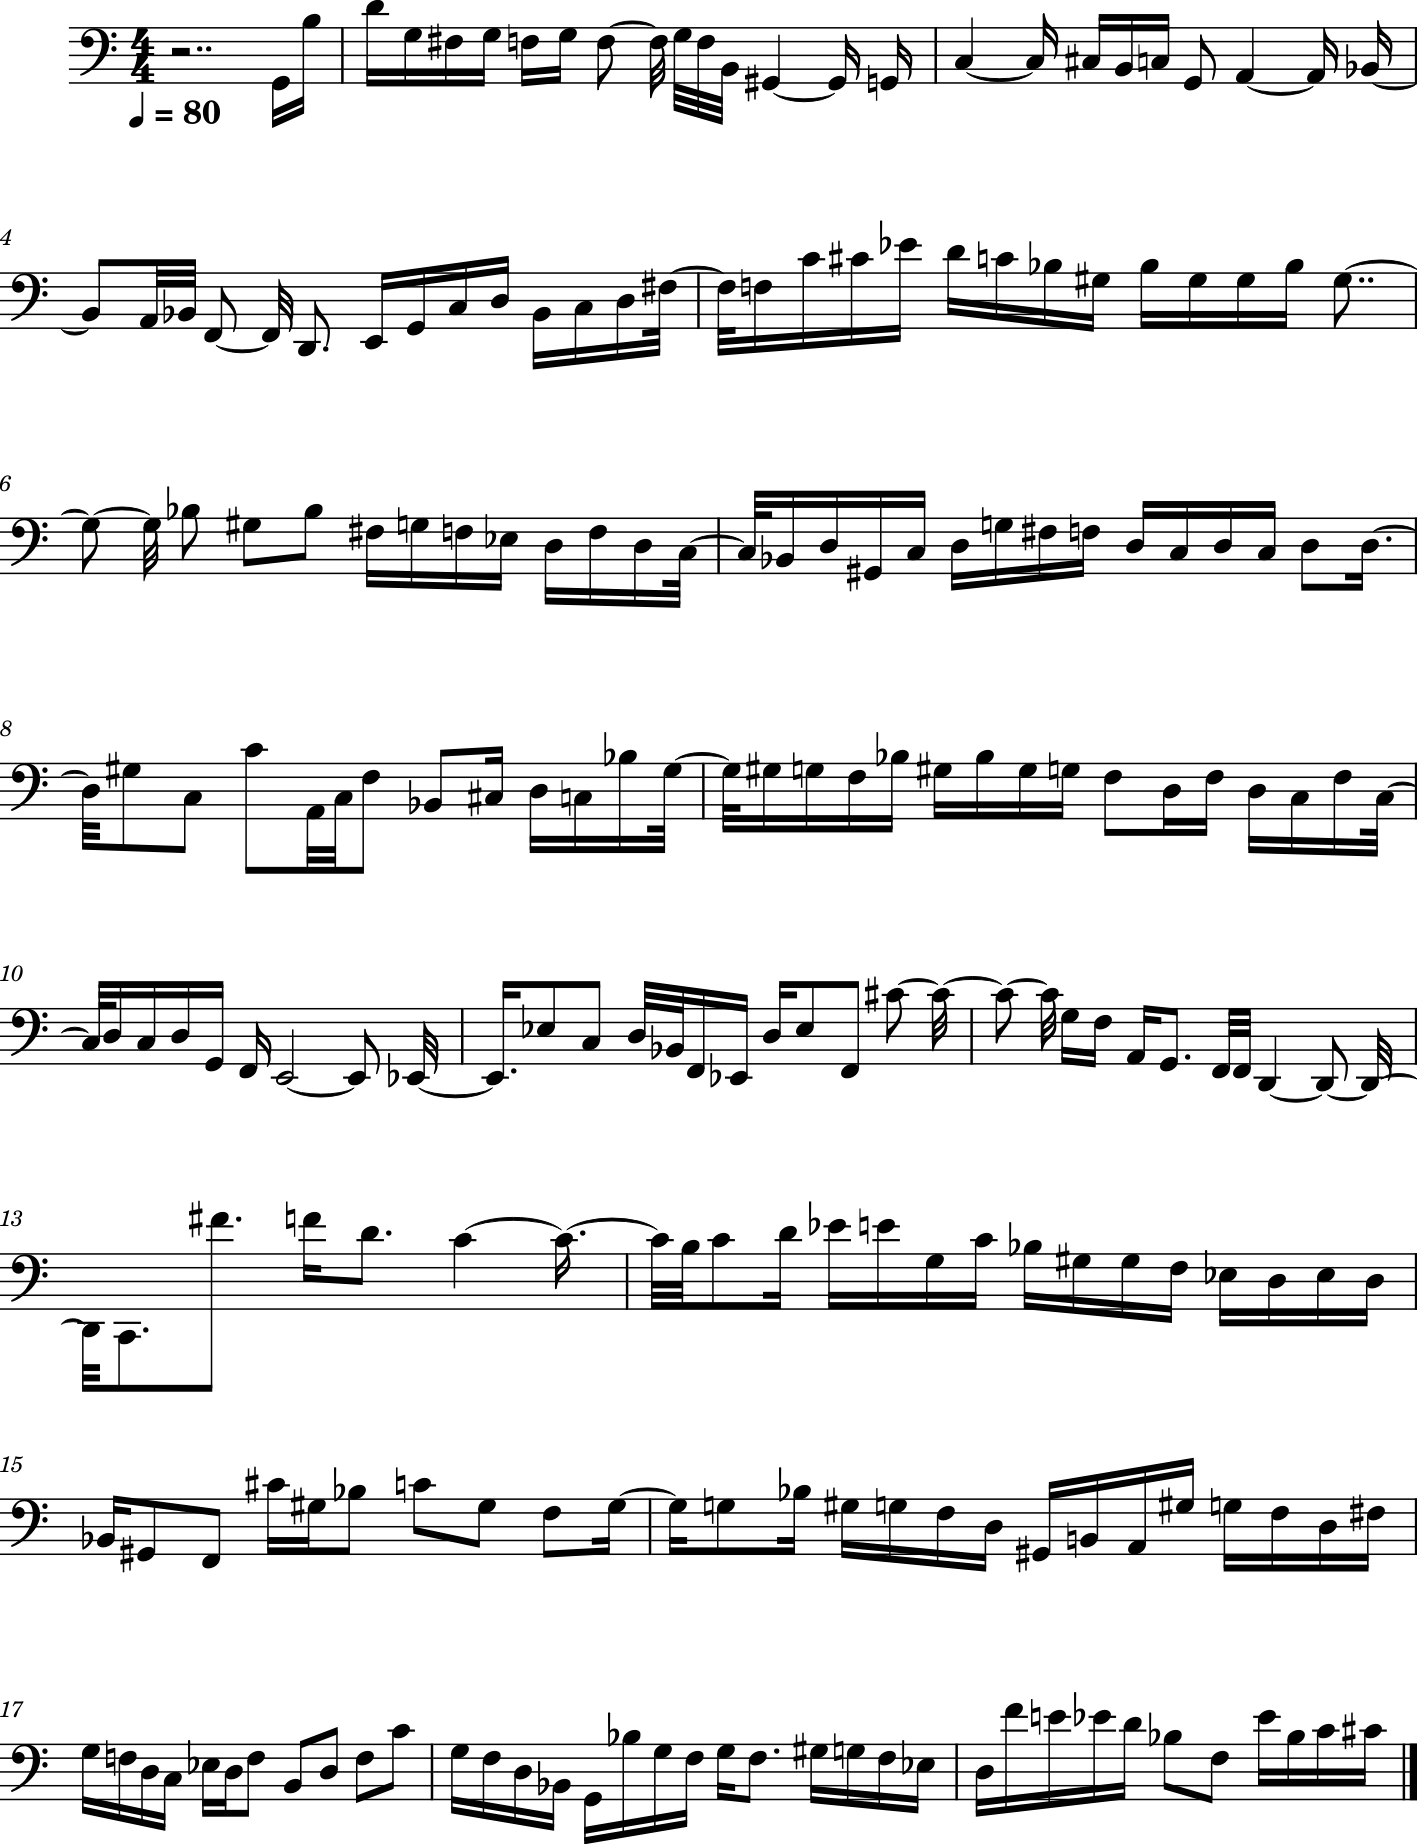

In [61]:
strm = stream.Stream()
mm = tempo.MetronomeMark(number=80)  # BPM = 80
strm.append(mm)  # tempo
strm.append(instrument.Violoncello())  # instrument
strm.append(meter.TimeSignature('4/4')) # time signature
n = note.Rest()
n.duration.quarterLength = onset/8
strm.append(n)
for i in range(len(Gen)):
    n = note.Note()
    n.pitch.midi = Gen['Note'][i]
    n.duration.quarterLength = Gen['Duration_32th'][i]/8
    strm.append(n)
strm.show()

In [62]:
strm.show('mid')

Congratulations! If you want to write out the generated piece into a MIDI file, please run the following codes:

The MIDI file is unified under parameters below:
- PPQ: 480
- BPM: 80 (Tempo: 750000)
- Time signature: 4/4
- Instrument: cello (Program_c: 42)

In [63]:
PPQ = 480
PP32 = int(PPQ/8)
time = int(onset * PP32)

In [64]:
generated_csv = open("midi.csv", 'w')
generated_csv.write("0,0,Header,0,1,480\n")
generated_csv.write("1,0,Start_track\n")
generated_csv.write("1,0,Tempo,750000\n")
generated_csv.write("1,0,Time_signature,4,2,24,8\n")
generated_csv.write("1,0,Program_c, 0, 42\n")

for i in range(len(Gen)):
    note = Gen['Note'][i]
    level = Gen['Structure_level'][i]
    if level == 0:
        velocity = np.random.randint(100,115)
    elif level == 1:
        velocity = np.random.randint(90,105)
    elif level == 2:
        velocity = np.random.randint(80,95)
    else:
        velocity = np.random.randint(75-5*(level-3),85-5*(level-3))
        
    generated_csv.write("1,"+str(time)+",Note_on_c,0,"+str(note)+","+str(velocity)+"\n")
    time += int(Gen['Duration_32th'][i]*PP32)
    generated_csv.write("1,"+str(time)+",Note_on_c,0,"+str(note)+",0\n")

end_time = time + PPQ
generated_csv.write("1," + str(end_time) +", End_track\n")
generated_csv.write("0, 0, End_of_file")
generated_csv.close()

In [65]:
# Parse the CSV output of the previous command back into a MIDI file
midi_object = pm.csv_to_midi("midi.csv")

# Save the parsed MIDI file to disk
with open("generated.mid", "wb") as output_file:
    midi_writer = pm.FileWriter(output_file)
    midi_writer.write(midi_object)